# **To Click or Not to Click**
#  An ensemble decision tree model to predict advertisement click through rate

> Course: w261 Final Project (Criteo Click Through Rate Challenge)

> Team Number:19

> Team Members: Steve Dille, Naga Akkineni, Joanna Yu, Pauline Wang

> Fall 2019: section 1, 3, 4

In [1]:
# import library
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import pyspark.sql.functions as f
# from pyspark.sql.functions import conv, mean, max, min
from pyspark.sql.functions import udf, isnan, when, count, col, broadcast, lit, avg
from pyspark.sql.types import LongType, IntegerType, DoubleType, FloatType
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, StandardScaler, OneHotEncoderEstimator
from pyspark.ml import Pipeline
from pyspark.mllib.util import MLUtils
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.window import Window
from pyspark.ml.feature import Imputer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
#import pydotplus
#import graphviz
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)


/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_proj"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
spark

# I. Question Formulation

Our goal in this machine learning project is to build a model that can predict advertising click through rates (CTR) better than a baseline model of guessing based on known click through percentages in the data set or by using an out-of-the box machine learning model. We seek to add value to the process.  This is an enormously valuable task which is why there is so much investment in machine learning and data science in the advertising area. Being able to have better predictions of what the factors that drive clickthrough rates are is valuable to both the buy side (advertising buyers) and the sell side (advertisement platforms or publishers).  If advertisers have better predictive power of clickthrough conversion rates, they can use this to determine expected sales from a campaign, where to advertise, how much they can spend as a profitable investment, or which platforms and publishers to advertise with.  On the sell side, if we are able to model and predict conversions, we could adjust pricing models to suit the advertisers who are interested in specific advertisement products and achieve higher revenue and greater customer satisfaction.

### Model Baseline and Evaluation

From our training dataset, the EDA shows that the ground truth is 25.62%, which means the same percentage of rows of data was converted to a click through.  So a simple baseline model could be built that always predicts that each data row is a click through which would result in model accuracy of 25.62%. A higher performing alternative to this baseline would be to train a machine learning classifier that needs little to no pre-processing of the data and use that as a reasonable cost alternative baseline. For us, at the end of the day, our model has to make advertisers or publishers more money and beat simple guessing based on percentages which we think is easily achievable.  And this is why we think accuracy is not a great metric to judge performance with and guessing is a low bar baseline. 

A better baseline would be to judge our work against an out of the box classifier. But when evaluating two different machine learning models, how can we judge which is better?  This is a highly situational question and the answer is it depends on many factors. In this situation, the cost of being wrong and not predicting a click through (assuming our client understands the full conversion of a click to profitability) is higher than the cost of low cost display ad spending. So we need a more nuanced view than just accuracy.  We want a model that takes into account the uncertainty of a prediction based on how much it varies from the actual label. We think **log loss** is the right metric to judge our model by as it takes into account and penalizes either model for being way off in its predicted probability from the true outcome.  This is important as we want to minimize the situation where the true outcome is a click through but the model gave low probability to that true outcome.  Log loss will do that by penalizing heavily a model that is off base in its prediction and the model that more closely aligns its probabilities with true outcomes will win this competition.  

The situation in which we must build this model is challenging.  We have been provided a data set of 11GB of training data that consists of integer values and categorical variables stored in hexadecimal format. There is no information available about what any of these fields represent so we will not be able to use intuition in feature selection.  We therefore will rely on machine learning to make sense of the data for us and choose the best predictors out of the data set.  Because of this situation, we have decided to use a **ensemble decision tree modeling approach** as this type of classifier does not require as much transformation or knowledge of the features we are given. We will also use random forest modeling, which really is a decision tree designed to improve results by utilizing the wisdom of the crowd by consolidating the predictions of many decision trees into one.  We will also apply gradient boosting which will provide us with a way for optimizing a decision tree model that avoids overfitting the model to the training data.
     


# II. Algorithm Explanation

We choose decision tree and random forest as our algorithm for the Criteo project because of the nature of the dataset we are given.  First of all, the data set contains both continuous numeric features and categorical features.   Second, as illustrated in the subsequent EDA section, the data set contains many missing values.   Decision tree/random forest algorithms are known to be robust handing data set with mixed features and missing values.  Last but not least, we are not given any information about what the features represent, and therefore, we want to keep the data preprocessing and feature selection to a minimum by simply grouping feature values in representative bins.

### Toy Data Preprocessing

In this section, we apply the data processing procedures on a tiny toy data set, which is about 0.01% of the training data. The math of how we preprocess the data is illustrated in this section, which will be replicated in the Algorithm Implementation Section. 

In [56]:
# We build a toy dataframe to illustration purpose with a subset of the training.txt 
df=pd.read_csv('toy_pauline.txt', sep='\t',names=['Label','I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9','I-10','I-11','I-12','I-13','C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24','C-25','C-26'])

In [57]:
# Quick exploratory data analysis - we take a look at the dataframe - UNCOMMENT TO SHOW DATA
#df.head(n=15)
# For reasons discuss in section III EDA, we drop I-12 and C-22 because they have more than 50% of missing values.
#Take a look at the summary statistics of the toy dataset
df=df.drop(['I-12','C-22'], axis=1)
df.describe(include='all')

,Label,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,...,C-16,C-17,C-18,C-19,C-20,C-21,C-23,C-24,C-25,C-26
count,5416.000000,2994.000000,5416.000000,4232.000000,4195.000000,5.273000e+03,4238.000000,5148.000000,5415.000000,5148.000000,...,5226,5416,5416,3062,3062,5226,5416,5226,3062,3062
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3026,10,947,380,3,3159,12,1783,35,1358
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84898b2a,e5ba7672,e88ffc9d,21ddcdc9,b1252a9d,0014c32a,32c7478e,3fdb382b,001f3601,49d68486
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121,2536,184,1867,1034,121,2388,263,775,213
mean,0.258309,3.316633,100.636078,29.605388,7.253874,1.740516e+04,112.574799,15.721834,12.236380,108.828477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.437745,8.170907,382.563705,559.061640,8.978072,6.227349e+04,266.076455,56.042054,13.686591,297.605133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,2.000000,2.000000,3.580000e+02,8.000000,1.000000,2.000000,10.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,1.000000,3.000000,6.000000,4.000000,2.777000e+03,32.000000,3.000000,7.000000,38.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,34.000000,17.000000,9.000000,1.006800e+04,100.000000,11.250000,19.000000,109.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Interger Features

The toy data set contains 13 integer features (I-1 to I-13) with values range from -2 to 1.3 millions and distributions with various degree of skewness and kurotisis.  Without knowledge of what these features represent, we err on the side of caution and simply normalize the feature value by replacing it withe the z-score. 

$$
Z_score = (X_i-miu_i)/\sigma_i\
$$

In [60]:
# Below is the process we use to normalize integer feature
def ScalerIndexer_PD(dataframe, column_list):
    '''This function calculates the z score of the integer features by deduct mean from the value and divide it by the standard deviation.  The missing values are filled with mean'''
    series_list=[]
    for i in column_list:
        miu=dataframe[i].mean()
        stdev=dataframe[i].std()
        series_list.append(df[i].fillna(miu).apply(lambda x: (x-miu)/stdev)) #We calculate the bin number by value divide by half of stdev and plus 1 (so the minimum bin number will be 1)
        s=pd.Series(series_list)
    result_pd=pd.DataFrame.from_items(zip(s.index, s.values)) #convert to panda dataframe
    result_pd.columns=column_list
    return result_pd

In [61]:
#process the numeric category I-1 to I-13 and take a look at the result
numeric_df=ScalerIndexer_PD(df,['I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9','I-10','I-11','I-13'])
numeric_df.head(n=5)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  # Remove the CWD from sys.path while we load stuff.


,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-13
0,-0.038751,-0.265671,-0.024336,1.085548,-0.277601,-0.160010,0.058495,2.028527,0.491159,0.575430,0.219756,4.672861
1,-0.405908,-0.263057,0.000000,0.000000,-0.245051,0.726953,-0.191318,0.786435,0.353393,-0.893315,0.219756,0.000000
2,-0.283522,-0.142816,-0.029702,0.305870,-0.279480,-0.389267,-0.262693,-0.163399,-0.332079,0.575430,-0.339280,-0.463746
3,0.000000,-0.260443,-0.051167,-0.362425,-0.279271,6.920662,-0.280536,1.151756,-0.110309,0.000000,-0.525626,-0.463746
4,-0.405908,-0.260443,0.081198,-0.139660,-0.200634,0.817153,-0.262693,-0.455656,-0.211114,-0.893315,-0.339280,-0.161593


In [62]:
# Take a look at the summary statistics of the processed data and make sure that there is no missing values
numeric_df.describe(include ='all')

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-13
count,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03,5.416000e+03
mean,-4.105811e-17,3.694935e-17,-3.929520e-17,1.172540e-17,-4.381650e-18,2.536745e-19,-3.304482e-16,1.430007e-16,1.559201e-17,-1.453785e-16,2.090790e-16,-2.574668e-17
std,7.434540e-01,1.000000e+00,8.839390e-01,8.800655e-01,9.867076e-01,8.845655e-01,9.749399e-01,9.999077e-01,9.749399e-01,7.434540e-01,9.749399e-01,8.800655e-01
min,-4.059076e-01,-2.682849e-01,-5.295550e-02,-8.079545e-01,-2.794956e-01,-4.230919e-01,-2.805364e-01,-8.940415e-01,-3.656808e-01,-8.933152e-01,-5.256256e-01,-6.148226e-01
25%,-2.835222e-01,-2.630570e-01,-4.758936e-02,-5.851895e-01,-2.731044e-01,-3.779921e-01,-2.626926e-01,-7.479131e-01,-3.287191e-01,-8.933152e-01,-3.392803e-01,-4.637459e-01
50%,0.000000e+00,-2.552152e-01,-3.506838e-02,-2.827708e-02,-2.335049e-01,-2.051095e-01,-2.091614e-01,-3.825920e-01,-2.245542e-01,0.000000e+00,-3.392803e-01,-8.605427e-02
75%,0.000000e+00,-1.741830e-01,0.000000e+00,0.000000e+00,-9.479417e-02,0.000000e+00,-3.072396e-02,4.941786e-01,0.000000e+00,5.754304e-01,3.341040e-02,0.000000e+00
max,2.211301e+01,2.222731e+01,5.644529e+01,2.180269e+01,2.392769e+01,1.320457e+01,3.148133e+01,2.263264e+01,4.510733e+01,4.981667e+00,1.587276e+01,2.952497e+01


## Categorical Features

The Criteo data set includes 26 categorical features that are hashed for anonymization. We use Brieman's theorem to process the unordered categorical feature in order to find the best split predicate for a categorical attribute, without evaluation all possible subsets.  In order to facilitate the process of calculating Brieman, we first rank the categorical values by their frequency, and only use the top 100 most frequently occur values. We label any categorical feature values that are not on the top 100 table as 999. For more information about how StringIndexer, please reference SparkMLlib Documentation [1] 

$$
B_i = avg(y_i|x_i)
$$

Where $B_i$ represents the output calculated using Brieman's theorem which equals to the mean target value of $y$ for each categorical value of the input variable $x$ (i.e. group by x).  Note that we add a 1 to the end of the bin number as to reserve 0 for missing values. 


In our toy data set, the categorical features have unique values range from 3 to over 3000.  The Breiman calculation works fine for the toy data set as the total unique values is only 15,000. However, further prior grouping may be required for the entire train data set to avoide run time error. 

[1] StringIndexer:https://spark.apache.org/docs/latest/ml-features.html#stringindexer


In [76]:
def StringIndexer_PD(df, label, column_list):
    '''We rank the categorical values by their frequency and replace the value with the rank. Rank above the 100th place will be labeled 999'''
    df=df.fillna('xxx') # fill the missing variable with a value to represent a separate category
    series_list=[]
    series_list.append(df[label])
    for col in column_list:
        pd_series=df[col].value_counts() #count the number of frequency
        pd_rank=pd.DataFrame({col:pd_series.index, 'Count':pd_series.values})
        pd_rank['Rank']=pd_rank['Count'].rank(ascending=False) #rank the number of frequency
        pd_rank.loc[pd_rank['Rank']>101,'Rank']=999 #replace any number greater than 101 with 999 
        
        series_list.append(pd_rank['Rank'])
        #Append and convert the panda series to panda dataframe
    s=pd.Series(series_list)
    result_pd=pd.DataFrame.from_items(zip(s.index, s.values))
    result_pd.columns=column_list #add the column header 
    return result_pd

In [67]:
df=df.fillna('xxx')
df.head()
xxx_df=df['C-20'].value_counts()
xxx_df.head(n=20)

xxx         2354
b1252a9d    1034
a458ea53    1032
5840adea     996
Name: C-20, dtype: int64

In [78]:
#df.groupby('C-1').count()
pd_series=df['C-10'].value_counts()
pd_rank=pd.DataFrame({'C-10':pd_series.index, 'Count':pd_series.values})
pd_rank['Rank']=pd_rank['Count'].rank(ascending=False)
pd_rank.loc[pd_rank['Rank']>101,'Rank']=999
x=pd_rank.loc


#series_list.append(dataframe[i].fillna(-2).apply(lambda y:0 if y ==-2 else lookup_table.loc[lookup_table[i]==y,column_list[0]].iloc[0]+1))
print(pd_rank.head(n=200))
type(pd_rank)
# new_table=lookup_table.loc[lookup_df['C-1'] > 1990, 'C-1'] = 1
# d


         C-10  Count   Rank
0    3b08e48b   1191    1.0
1    efea433b     58    2.0
2    fbbf2c95     42    3.0
3    fa7d0797     37    4.0
4    03e48276     35    5.0
5    f6f942d1     29    6.0
6    5162b19c     28    7.0
7    451bd4e4     26    8.0
8    49d1ad89     22   10.0
9    711ec2bc     22   10.0
10   299aecf1     22   10.0
11   31990058     21   12.5
12   67eea4ef     21   12.5
13   935a36f0     19   14.0
14   5ba575e7     18   15.0
15   6c47047a     16   16.0
16   547c0ffe     15   17.0
17   305a0646     14   18.5
18   000e2f4b     14   18.5
19   2462946f     13   21.5
20   4072f40f     13   21.5
21   a1ee64a6     13   21.5
22   e7ba2569     13   21.5
23   474773a7     12   27.0
24   9a1250bd     12   27.0
25   4b4670a5     12   27.0
26   015ac893     12   27.0
27   03ed27e7     12   27.0
28   d2f1c80c     12   27.0
29   eab78bab     12   27.0
..        ...    ...    ...
170  e851ff7b      4  999.0
171  4b8a7639      4  999.0
172  d108fc83      4  999.0
173  3bc8bb1a      4

pandas.core.frame.DataFrame

In [77]:
category_df=StringIndexer_PD(df,'Label',['C-1','C-20','C-3'])
#category_df=StringIndexer_PD(df,['C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-23','C-24','C-25','C-26'])
category_df.head(n=20)

05db9164    2709
68fd1e64     891
5a9ed9b0     416
8cf07265     281
be589b51     178
5bfa8ab5     132
87552397     111
f473b8dc      74
ae82ea21      61
39af2607      47
9a89b36c      40
17f69355      38
241546e0      36
09ca0b81      32
439a44a4      25
75ac2fe6      22
41edac3d      22
fbc55dae      16
3c9d8785      14
1464facd      14
7e5c2ff4      14
46300ee3      11
b455c6d7      11
d4b08d58       9
291b7ba2       8
da4eff0f       8
24eda356       8
489d0f96       7
28e55712       7
65aada8c       7
            ... 
1ece7099       1
c35dc981       1
783e033b       1
af4bea71       1
fb892f9b       1
5bdf48e7       1
b19f768d       1
9660b97b       1
f434fac1       1
c6dce90e       1
48f8c5b9       1
686e2eff       1
45cb84c9       1
e0b243e1       1
1cff288d       1
340c148e       1
bd3ff405       1
127f4a6b       1
36a5b3ff       1
4460e33a       1
9e9d28f5       1
5e53cc38       1
92fb1d87       1
70d60005       1
dd14f377       1
da41329b       1
90680a2b       1
fa563475      

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  app.launch_new_instance()


,C-1,C-20,C-3
0,1.0,1.0,1.0
1,2.0,2.0,2.0
2,3.0,3.0,3.0
3,4.0,4.0,4.0
4,5.0,NaN,5.0
5,6.0,NaN,6.0
6,7.0,NaN,7.0
7,8.0,NaN,8.0
8,9.0,NaN,9.0
9,10.0,NaN,10.0


In [23]:
def Breiman(dataframe, Label, column_list):
    '''We apply breiman's theorem for the unordered categorical attirubtes C-1 to C-26'''
    series_list=[]
    series_list.append(dataframe[label])#add the label to first column
    for col in column_list:#first value is the label
        lookup_table=dataframe.groupby(col, as_index=False)[label].mean()
        #Below we replace all the number with the mean of label plus 1 (we reserve 0 for missing values)  
        series_list.append(col.fillna(-2).apply(lambda y:0 if y ==-2 else lookup_table.loc[lookup_table[i]==y,column_list[0]].iloc[0]+1))
          #Append and convert the panda series to panda dataframe
    s=pd.Series(series_list)
    result_pd=pd.DataFrame.from_items(zip(s.index, s.values))
    result_pd.columns=column_list #add the column header 
    return result_pd

In [18]:
# We process all the categorical features 
category_df=Breiman(df,'Label',['C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-23','C-24','C-25','C-26'])
category_df.head(n=20)

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,...,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
0,0,1.248036,1.160000,1.000000,1.000000,1.256318,1.256410,1.000000,1.277902,1.271270,...,1.275058,1.160000,1.232458,1.225904,1.000000,0.000000,1.273451,1.000000,1.232172,1.000000
1,0,1.325000,1.307568,1.000000,1.000000,1.243243,1.245056,1.285714,1.253750,1.271270,...,1.313091,1.400000,0.000000,0.000000,1.000000,0.000000,1.224954,1.400000,0.000000,0.000000
2,0,1.263345,1.050000,1.094340,1.160920,1.256318,1.245056,1.111111,1.253750,1.271270,...,1.189147,1.071429,0.000000,0.000000,1.094340,0.000000,1.273451,1.213043,0.000000,0.000000
3,0,1.248036,1.090909,1.203704,1.240385,1.264938,1.245056,1.133333,1.253750,1.271270,...,1.159091,1.095238,1.232458,1.225904,1.203704,0.000000,1.289474,1.236735,1.232172,1.250000
4,0,1.263345,1.239362,1.000000,1.000000,1.256318,0.000000,1.000000,1.277902,1.271270,...,1.159091,1.234483,1.000000,1.253876,1.000000,0.000000,1.273451,1.000000,1.232172,1.000000
5,0,1.264673,1.285714,1.000000,1.000000,1.264938,1.250817,1.000000,1.253750,1.271270,...,1.313091,1.296296,1.200000,1.253876,1.000000,0.000000,1.224954,1.000000,1.232172,1.000000
6,1,1.264673,1.285714,2.000000,2.000000,1.256318,1.259615,1.309091,1.277902,1.271270,...,1.313091,1.271739,1.500000,1.253876,2.000000,0.000000,1.236702,2.000000,1.265766,2.000000
7,1,1.263345,1.223077,2.000000,1.240385,1.274112,0.000000,2.000000,1.205128,1.271270,...,1.313091,1.250000,1.232458,1.225904,2.000000,0.000000,1.273451,1.236735,1.232172,1.281250
8,0,1.278689,1.255556,1.000000,1.000000,1.256318,1.250817,1.000000,1.277902,1.271270,...,1.220339,1.254237,1.200000,1.253876,1.000000,0.000000,1.236702,1.231939,1.207742,1.197183
9,0,1.000000,1.255556,1.000000,1.000000,1.256318,1.250817,1.000000,1.253750,1.271270,...,1.189147,1.254237,1.000000,1.268859,1.000000,0.000000,1.236702,1.000000,1.232172,1.000000


In [20]:
# Take a look at the summary statistic of the categorical features of the toy data set. 
category_df.describe(include ='all')

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,...,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
count,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,...,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000
mean,0.258309,1.258309,1.258309,1.211780,1.211780,1.258309,1.093796,1.258309,1.258309,1.258309,...,1.258309,1.258309,0.706610,0.706610,1.211780,0.300037,1.258309,1.211780,0.706610,0.706610
std,0.437745,0.066230,0.135077,0.428519,0.393410,0.039172,0.418975,0.295167,0.050404,0.038655,...,0.069824,0.210630,0.630667,0.619756,0.416879,0.540630,0.057952,0.349211,0.621730,0.659860
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.248036,1.184834,1.000000,1.000000,1.256318,1.245056,1.000000,1.253750,1.271270,...,1.220339,1.137255,0.000000,0.000000,1.000000,0.000000,1.224954,1.000000,0.000000,0.000000
50%,0.000000,1.264673,1.250000,1.000000,1.127717,1.256318,1.250493,1.200000,1.253750,1.271270,...,1.313091,1.234483,1.142857,1.225904,1.055556,0.000000,1.273451,1.226190,1.207742,1.000000
75%,1.000000,1.264673,1.307568,1.363636,1.380000,1.259475,1.250817,1.411111,1.257500,1.271270,...,1.313091,1.333333,1.232458,1.253876,1.363636,0.000000,1.273451,1.324786,1.235012,1.197183
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.388889,2.000000,2.000000,1.271270,...,1.318182,2.000000,2.000000,1.268859,2.000000,2.000000,1.361409,2.000000,2.000000,2.000000


In [21]:
#We now put two dataframe together
new_df = pd.concat([category_df, numeric_df], axis=1)
new_df.head(n=10)

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,...,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
0,0,1.248036,1.160000,1.000000,1.000000,1.256318,1.256410,1.000000,1.277902,1.27127,...,4,1,1,1,6,2,3,2,1,11
1,0,1.325000,1.307568,1.000000,1.000000,1.243243,1.245056,1.285714,1.253750,1.27127,...,0,1,3,1,4,2,1,2,0,0
2,0,1.263345,1.050000,1.094340,1.160920,1.256318,1.245056,1.111111,1.253750,1.27127,...,3,1,1,1,2,1,3,1,1,1
3,0,1.248036,1.090909,1.203704,1.240385,1.264938,1.245056,1.133333,1.253750,1.27127,...,1,1,15,1,5,1,0,1,0,1
4,0,1.263345,1.239362,1.000000,1.000000,1.256318,0.000000,1.000000,1.277902,1.27127,...,2,1,3,1,1,1,1,1,0,1
5,0,1.264673,1.285714,1.000000,1.000000,1.264938,1.250817,1.000000,1.253750,1.27127,...,0,1,1,1,1,1,0,1,0,0
6,1,1.264673,1.285714,2.000000,2.000000,1.256318,1.259615,1.309091,1.277902,1.27127,...,1,1,1,1,1,1,3,1,0,1
7,1,1.263345,1.223077,2.000000,1.240385,1.274112,0.000000,2.000000,1.205128,1.27127,...,2,1,1,1,1,1,0,2,1,1
8,0,1.278689,1.255556,1.000000,1.000000,1.256318,1.250817,1.000000,1.277902,1.27127,...,1,1,1,1,1,1,1,1,0,1
9,0,1.000000,1.255556,1.000000,1.000000,1.256318,1.250817,1.000000,1.253750,1.27127,...,9,1,1,1,6,1,3,1,0,8


In [22]:
new_df.describe(include='all')

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,...,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
count,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,...,5416.000000,5416.000000,5416.000000,5416.000000,5416.000000,5416.00000,5416.000000,5416.000000,5416.000000,5416.000000
mean,0.258309,1.258309,1.258309,1.211780,1.211780,1.258309,1.093796,1.258309,1.258309,1.258309,...,1.698301,1.344350,1.228397,1.281019,2.390694,1.37260,1.275295,1.607090,0.322563,1.421898
std,0.437745,0.066230,0.135077,0.428519,0.393410,0.039172,0.418975,0.295167,0.050404,0.038655,...,1.979256,1.925136,1.827484,1.909895,1.938829,1.91616,1.669372,1.922116,1.087449,1.894686
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.248036,1.184834,1.000000,1.000000,1.256318,1.245056,1.000000,1.253750,1.271270,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.264673,1.250000,1.000000,1.127717,1.256318,1.250493,1.200000,1.253750,1.271270,...,1.000000,1.000000,1.000000,1.000000,2.000000,1.00000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.264673,1.307568,1.363636,1.380000,1.259475,1.250817,1.411111,1.257500,1.271270,...,2.000000,1.000000,1.000000,1.000000,3.000000,1.00000,3.000000,2.000000,0.000000,2.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.388889,2.000000,2.000000,1.271270,...,46.000000,49.000000,28.000000,64.000000,48.000000,91.00000,12.000000,33.000000,30.000000,61.000000


## Toy Decision Tree 

### Classificaiton Decision Tree

A decision tree represents a hierarchical segmentation of the data with the goal to divide the data into parts of homogenous values.  The breakdown of a data set is structured in the form of a tree shape with tree nodes and leaf nodes prepresenting each of the splits.  For our project, we choose a classification  decision tree as opposed to a regression tree since our desired output is binary (e.g. whether or not an advertisement will be clicked on : 0=not clicked, 1=clicked).  At any given time, the probability of the label being 0 (not clicked on) or 1 (clicked on ) at node m, representing a region $R_m$ with $N_m$ is:

$$
\widehat{p_mk}= \ (1/N_m)\sum I(y_i=k)
$$


Different from a regression tree where the data split is typically based on the purity of the segmentation (variance), a classification tree divides the data based on information gain (e.g. how much a given attributes X tells us about the output Y).   Information gain can be calculated based on misclassification error, Gini index, or entropy, and we use entropy in our model as it is more sensitive to changes in the node probabilities than misclassificaiton error.  The split of a classificaiton tree is based on the highest information gain (e.g. maximum decrease in entropy), and they are represented by the following formula: 

$$
Entropy\; H(X) = -\sum p(X)\log p(X)\\ Information\ Gain\; I(X,Y)= H(X)-H(X|Y)
$$

Building a decision tree on a single node is a greedy induction process. The model calculates information gain for all possible splits to find the "best split" and grow the tree accordingly until a stopping criteria is reached.  This presents a challenge for large-scaled machine learning as the data cannot be stored in memory, and we will be explain further in the following section.  


### Classification Decision Tree in a Distributed Framework

Though decision tree is a powerful and popular machine learning algorithm, performing decision tree on a large scale remains a challenge as finding the best split typically requires a full scan of each node's input data, which can be enormous at the top of the tree.  Memory insufficiency is another obstacle with large input which increases the cost of transmitting data to and from secondary storage.  Loading data into memory also requires significant resources, even at the lower level of the tree, as the process requires partitioning data to a secondary storage multiple times.  

Scaling up tree learning to large datasets is an area of active research interest. One of the most notable paper is the PLANET(Massively Parallel Learning of Tree Ensembles with MapReduce) by the team at Google [1]. The decision tree at scale is grown one level at a time, as opposed to one decision node at a time. As such, it is highly amenable to parallelization.  Below we describe the process of how a classification decision tree is performed in a distributed framework on a high level [2]:    

>Step 1: Training data is partitioned across $m$ machines (all feature values are completed in a partition but the values are separated).  Master requests workers to expand a set of nodes for each partition. 

>Step 2: Wrokers pass through all instances for local features and aggregate "incomplete" histograms based on the data fall into that node. This is followed by shuffling the local "incomplete" historigrams and aggregate the complete histograms with respect to a single feature.    

>Step 3: The workers select the best "local" splits based on information gain (for classification tree). 

>Step 4: The best splits of all feautres are aggregated to master who then select the best feature.   

>Step 5: The master than records the newly split tree structure and broadcasts the best splitting information to all workers. 

>Step 6: The workers then independently compute the information that records the tree node with a sample residuals after a split.

>Step 7: Process is repeated until stopping criteria is reached. 

[1] Biswanath Panda, and Joshua S. Herbach et al. "PLANET: Massively Parallel Learning of Tree Ensembles
with MapReduce" Google: 2009.  https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36296.pdf

[2] A Spark Decission Tree Regression https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-trees

### Decision Tree Building

Below we illustrate the process of building a decision tree on a single node using the sklearn library.  


In [28]:
#Build train and test set from toy sample
X=np.asarray(new_df['Label'])
Y=np.asarray(new_df.loc[0:,'C-1':'I-13']) 
train_labels, test_labels, train_data, test_data = train_test_split(X, Y, test_size=0.2, random_state=10)

In [29]:
def entropy(distribution):
    h = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: logprob = np.log2(probability)
        h -= probability * logprob
    return h

In [ ]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy')#,max_depth=10, min_samples_split=10) #The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
dt.fit(train_data, train_labels)
print ('Accuracy:', dt.score(test_data, test_labels))

# Export the trained tree so we can look at it.
output_name = "toy-decisiontree.png"
dot_data = StringIO()
tree.export_graphviz(dt, out_file=dot_data, feature_names=['C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24','C-25','C-26','I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9','I-10','I-11','I-12','I-13'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_png(output_name):
    print ('Output:', output_name)
    display(Image(filename=output_name))

### Ensemble of Decision Trees -  Random Forest 

The random forest algorithm is an ensemble classifier algorithm based on the decision tree model.  It generates a specific number of training subsets from an original dataset using a bootstrap sampling approach.  The same number of decision tree is then build by traiing these subsets.  A randome forest is eventually constructed from these decision tree, and classificatino result is returned depending on the votes of these trees.  

Random forest tend to outperform a single decision tree because it minimizes the vairance by training on a different subsets of the training data. It also avoides the decision tree pitfall of overfitting by randomly select a number of features.  Bagging (sample with replacement) and boosting (trees are build one another and learn sequentially) are two common method to increase the predictive power of the model.  In our model, we use gradient boosting for optimal model performance, a method that utilizes the residual of the previous trees to refine the subsequent trees. (STEVE - ANYTHING YOU WANT TO ADD HERE?) 

Random forest is a suitable algorithm for large data as the trees can be trainied in parallel.  In the paper published by Chen et al [3], the team at IEEE constructed a Parallel Random Forest (PRF) based on the Apache Spark platfrom. optimizing Their PRF model, which is similiar to Spark Mllib Random Forest [4], utilizes both task and data parallelization.  Below are the procedures of the PRF on a high level:

>Step 1: Partition training data into individual subsets of RDD objects.  The data indices are saved in a separate table for recording the information gain of each partition. 

>Step 2: Data subsets are allocated to individual slave nodes. The tasks in the slave nodes are run by separate decision trees. 

>Step 3: The intermediate result of each slave nodes are aggregated with its respective features and sent to master to build meta decision trees in PRF (Each decision tree of PRF is built independent of each other,and each slave node of a decision tree is also split independently). 

>Step 4: A task DAG is constructed for each decision tree which includes the informaiton gains of feature subsets, the intermediate "best split" information, and the data index list. 

>Step 5: DAGs are then submitted ot the Spark task schedule ths monitor and split the job into different stages and tasks for prediction. 


*[3]: Chen, Jianguo and Kenli Li et all, "A Parallel Random Forest Algorithm for Big Datain a Spark Cloud Computing Environment": 2016. https://www.researchgate.net/publication/309055895_A_Parallel_Random_Forest_Algorithm_for_Big_Data_in_a_Spark_Cloud_Computing_Environment
*[4]: A. Spark, “Spark mllib - random forest,” Website,June 2016, http://spark.apache.org/docs/latest/mllib-ensembles.html

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Create the model with 100 trees
# model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_leaf_nodes=5,criterion='entropy')
# # Fit on training data
# model.fit(train_data, train_labels)

In [ ]:
# # Actual class predictions
# rf_predictions = model.predict(test_data)
# print(rf_predictions)
# print(sum(rf_predictions))
# print(len(test_labels))
# print("the predicted CTR is:", sum(rf_predictions)/len(test_labels))
# # Probabilities for each class
# rf_probs = model.predict_proba(test_data)[:, 1] #show the split node probability
# print(rf_probs)

In [ ]:
# print("=== Confusion Matrix ===")
# print(confusion_matrix(test_labels, rf_predictions))
# print('\n')
# print("=== Classification Report ===")
# print(classification_report(test_labels, rf_predictions))
# print('\n')
# print("=== All AUC Scores ===")
# #print(rfc_cv_score)
# print('\n')
# print("=== Mean AUC Score ===")
# #print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

# III. Exploratory Data Analysis

### Data Introduction


The dataset contains feature values and click feedback for millions of display ads served by Criteo.  The training set consists of a sampled of Criteo's 7 day traffic with each row corresponds to a display ad. The first column in the train data indicates whether this ad has been clicked or not (1 = clicked, 0 = not-clicked).  The first 13 columns taking integer value represent count features, and the following 26 columns represent categorial features that have been hashed for anonymization purposes.  If a value if missing, the field is empty.  The test dataset is computed in the same way as the training set but the data is taking from next day (8th day) following training period.  The first column of the test set has been removed for valuation purpose.

### Reading in Data
The training and test data are stored in tab-delimited text format. We did a 80/20 split on train.txt so we can use 80% of the data for training and 20% for validation. The resulting files were converted to Parquet by: 

> 1) Split the file into 80/20 and tokenized the raw data into 40 fields (1 label and 39 features).

> 2) Create Spark Dataframe and name the 40 fields - 'Label', 'I-1' through 'I-13', and 'C-1' through 'C-26'.

> 3) Create a Parquet file from the Dataframe. 

There is overhead cost to converting to Parquet but the columnar storage format will provide significant speed gain as the Dataframe can access the relevant column without parsing through the whole row. 

Once the conversion to Parquet is successful, we can begin the analysis. We begin by loading the Parquet files into Spark Dataframe format and cast the numeric features into Integer Type. 

The code of of splitting and converting the data is included in the addendum section. 

### Toy Dataset
A toy dataset has been created by randomly selecting 1.5% of the data from the training set and pre-processed using the same method above. The size of the toy dataset is ideal in that it allows us to take advantage of the Pandas Dataframe as well as the Spark Dataframe. 

To ensure that the toy dataset is a good representation of the training set, we compare the label distribution of the two datasets. The training set contains 36,667,561 data points with 25.62% click through rate. The toy dataset contains 549,101 data points with 25.60% click through rate so it is a valid sample. 

In [5]:
# THIS WILL NOT RUN UNLESS THE PARQUET FILES ARE AVAILABLE #
# create spark dataframes from the Parquet files. 
toyDF = spark.read.load('data/toy_naga.parquet')
trainDF = spark.read.load('data/train_80.parquet')
validationDF = spark.read.load('data/validation_20.parquet')
testDF = spark.read.load('data/test.parquet')
miniValDF = spark.read.load('data/miniValidation.parquet')

In [6]:
# Process Label and I-1 through I-13 by casting to integers ###
def prep_df(DF):
    #convert Label and all Integer columns to Ints and Categorical to Longs. 
    DF = DF.withColumn('Label', DF['Label'].cast(IntegerType()))
    for i in range(1,14):
        feature = 'I-'+str(i)
        DF = DF.withColumn(feature, DF[feature].cast(IntegerType()))    
    return DF
    

In [7]:
# Process the integer features for each dataframe.
toyDF = prep_df(toyDF)  # toy dataset (random 1.5% sample of training set)
trainDF = prep_df(trainDF) # full training set
validationDF = prep_df(validationDF) # full validation set
testDF = prep_df(testDF) # full test set
miniValDF = prep_df(miniValDF) # toy validation set (random 1.5% sample of validation set)

With all the dataframes loaded in and their integer features cast to integers, the EDA process can begin. We analyze the toy dataset by first filling the missing values with zeros and converting it to Pandas dataframe. The preprocessing required for the model is still to be determined. Filling in the missing values with zeros at this point allows us to perform the EDA in Pandas and plot graphs. Pandas is ideal for small dataset such as the toy data. 

Total Lines of Data in Train Dataset:  36667561
Label Distribution in Train Dataset: 
0	0.7438
1	0.2562

Total Lines of Data in Toy Dataset:  549101
Label Distribution in Toy Dataset: 
0	0.7440
1	0.2560



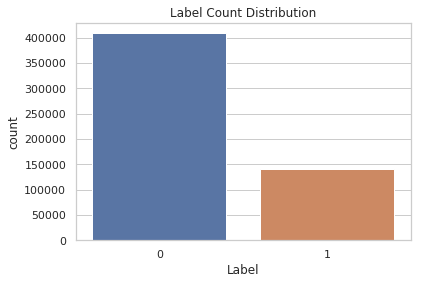

In [13]:
# Create a Pandas Dataframe from the Spark Dataframe.
toyDF_PD = toyDF.fillna(0).toPandas()
toyDF_PD.to_pickle('toyDF_PD.pkl')

# Assess percentage of label categories
trainDF_count = trainDF.count()
trainDF_CTR = trainDF.filter(trainDF.Label==1).count()/trainDF_count
print('Total Lines of Data in Train Dataset: ', trainDF_count)
print('Label Distribution in Train Dataset: ')
print('0\t{:.4f}\n1\t{:.4f}\n'.format(1-trainDF_CTR, trainDF_CTR))

toyDF_count = toyDF.count()
toyDF_CTR = toyDF.filter(toyDF.Label==1).count()/toyDF_count
print('Total Lines of Data in Toy Dataset: ', toyDF.count())
print('Label Distribution in Toy Dataset: ')
print('0\t{:.4f}\n1\t{:.4f}\n'.format(1-toyDF_CTR, toyDF_CTR))

# plot distribution of label counts
sns.set(style="whitegrid")
ax = sns.countplot(x="Label", data=toyDF_PD)
ax.set(title="Label Count Distribution")
plt.show()

### Summary Statistics
We can now begin running summary statistics on the training set. Despite the large size of the training set (> 8GB), we can leverage the Spark DataFrame with Parquet to calculate the summary statistics. The numbers will also guide our analysis on the toy dataset. 

Almost all of the integer features (I-1 through I-13) have mean values less than 200. Six of them have mean values less than 10. But the range of each feature is much higher than the mean. In particular, feature I-5 has very wide range (0 to 23,149,456) with 443,649 unique values. This means we expect to see a very skewed distribution. 

Since the categorical features have been hashed into hexidemical, summary statistics such as min, max, mean, and standard deviation become less meaningful. In terms of missing values, 14 categorical features have no missing values at all. As for the number of unique elements, 7 categorical features contain < 30 unique values while 5 features contain > 1 million unique values. The number of unique elements per feature ranges from 3 to over 8 million. We will have to deal with the high number of unique feature values when we begin modeling.  

### Challenges

#### No Feature Labels
One of the major challenges in this dataset is the lack of information about the features. We have no idea what the features represent so we cannot apply any possible prior knowledge about possible correlations among the features or between the feature and the click-through rate. This makes feature engineering somehwat difficult. And in addition, the 26 categorical features have been hashed into hexideicmal for anonymization purposes. It is as if one is modeling in the dark with a bunch of meaningless numbers. 

#### Missing Values
The issue of missing values is definitely a problem for this dataset. In the training set, there are a total of 36,667,561 rows of data. Only 605,255 rows  (1.65%) contain non missing values in every field. 

Features I-2, C-1, C-2, C-5, C-7, C-8, C-9, C-10, C-11, C-13, C-14, C-15, C-17, C-18, and C-23 have no missing values at all. Two features, I-12 and C-22, have a significant portion of missing values (> 76%). These two features will be excluded from our model. Six features (I-1, I-10, C-19, C-20, C-25, C-26) contain 43-45% of missing values. We are also seeing similarities in the following features, which may suggest certain level of correlation: 

* features I-7, I-9, I-11 with the same percentage (4.33%)
* features I-1, I-10 with the same percentage (45.36%)
* features C-3, C-4, C-12, C-16, C-21, C-24 with the same percentage (3.40%)
* features C-19, C-20, C-25, C-26 with the same percentage (44.01%)

### Treatment of Categorical Values
We immediately realize one-hot encoding would not be feasible since some of the categorical features have an unusual number of unique elements (in the millions range). 
* C-3  with 8,381,488 unique values
* C-4  with 1,884,275 unique values
* C-12 with 6,953,179 unique values
* C-16 with 4,591,131 unique values
* C-21 with 5,894,940 unique valeus

In [179]:
def sum_stats(DF):
    result = []
    DF_count = DF.count()
    for i in range(1,14):
        feature = 'I-'+str(i)
        DF = DF.withColumn(feature, DF[feature].cast(IntegerType()))
        feature_max = DF.agg({feature: 'max'}).collect()[0][0]
        feature_min = DF.agg({feature: 'min'}).collect()[0][0]
        feature_mean = DF.agg({feature: 'mean'}).collect()[0][0]
        feature_sd = DF.agg({feature: 'stddev'}).collect()[0][0]
        na_count = DF.filter((DF[feature]=='') | DF[feature].isNull()).count()
        feature_distinct = DF.select(feature).distinct().count()
        result.append([feature, 'Integer', feature_min, feature_max, feature_mean, feature_sd, 
                        DF_count-na_count, na_count, na_count/DF_count, feature_distinct])

    for i in range(1, 27):
        feature = 'C-'+str(i)
        na_count = DF.filter((DF[feature]=='') | DF[feature].isNull()).count()
        feature_distinct = DF.select(feature).distinct().count()
        result.append([feature, 'Categorical', None, None, None, None, DF_count-na_count, na_count, 
                        na_count/DF_count, feature_distinct])

    return pd.DataFrame(result, columns=['Feature', 'Type', 'Min', 'Max', 'Mean', 'Std Dev', 
                                         '# of Non-NAs', '# of NAs', '% of NAs', '# of Unique Elements'])

summary_PD = sum_stats(spark.read.load('data/train_80.parquet'))
summary_PD

,Feature,Type,Min,Max,Mean,Std Dev,# of Non-NAs,# of NAs,% of NAs,# of Unique Elements
0,I-1,Integer,0.0,5775.0,3.503312,9.464759,20034538,16633023,0.453617,617
1,I-2,Integer,-3.0,257675.0,105.823726,391.756169,36667561,0,0.000000,8958
2,I-3,Integer,0.0,65535.0,26.988332,400.725900,28795074,7872487,0.214699,13090
3,I-4,Integer,0.0,933.0,7.323369,8.797942,28718615,7948946,0.216784,470
4,I-5,Integer,0.0,23159456.0,18535.176923,69374.357021,35721274,946287,0.025807,443649
5,I-6,Integer,0.0,431037.0,116.061023,382.614752,28465113,8202448,0.223698,10916
6,I-7,Integer,0.0,56311.0,16.334247,66.263232,35079659,1587902,0.043305,3924
7,I-8,Integer,0.0,6047.0,12.518079,16.709297,36649334,18227,0.000497,1264
8,I-9,Integer,0.0,29019.0,106.121616,220.082729,35079659,1587902,0.043305,6931
9,I-10,Integer,0.0,11.0,0.617503,0.684029,20034538,16633023,0.453617,13


In [182]:
summary_PD.to_pickle('summary.pkl')

### Exploratory Data Analysis on Toy Dataset

#### Integer Features
We will now examine the distribution of the integer features by looking at the mean, median, and histograms of each features. All 13 integer features (I-1 through I-13) are highly skewed with median values close to zero in most cases. 

In [21]:
# Explore mean values of integer variables with respect to label categories.
feature_list = []
for i in range(1,14): feature_list.append('I-'+str(i))
feature_list
toyDF_PD.groupby(toyDF_PD.Label)[feature_list].mean().round(2)

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
Label,,,,,,,,,,,,,
0,2.93,96.33,24.13,7.61,21689.39,136.33,13.13,12.80,103.88,0.54,2.27,0.68,9.00
1,4.77,135.38,32.65,6.47,9197.56,66.79,25.59,11.68,113.59,0.79,4.08,1.75,5.94


In [24]:
# Explore median values of integer variables with respect to label categories.
toyDF_PD.groupby(toyDF_PD.Label)[feature_list].median()

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
Label,,,,,,,,,,,,,
0,1.0,3,7.0,4.0,3379.0,43.0,2.0,8.0,39.0,0.0,1.0,0.0,5.0
1,2.0,3,5.0,4.0,1369.0,14.0,6.0,6.0,37.0,1.0,2.0,0.0,3.0


Upon examinig the histograms for all 13 integer features, we see that they are all very similar. We show the histogram for feature I-1 as an example. 

I-1
[  0.   50.2 100.4 150.6 200.8 251.  301.2 351.4 401.6 451.8 502. ]


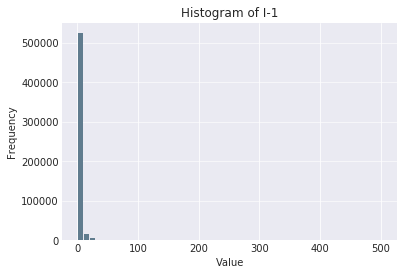

In [11]:
toyDF_PD = pd.read_pickle('toyDF_PD.pkl')
for i in toyDF_PD.iloc[:,1:2]:
    # The leftmost and rightmost bin edges
    first_edge, last_edge = toyDF_PD[i].min(), toyDF_PD[i].max()

    n_equal_bins = 10  # NumPy's default
    bin_edges = np.linspace(start=first_edge, stop=last_edge, num=n_equal_bins + 1, endpoint=True)
    print(i)
    print(bin_edges)
    
    toyDF_PD[i].plot.hist(grid=True, bins=50, rwidth=0.9,color='#607c8e')
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of '+ str(i))
    maxfreq = toyDF_PD[i].max()
    plt.show()

### Heatmap for Integer Features
As shown in the heatmap, most features have very low correlation numbers. Only 4 feature pairs have correlation $\geqslant$ 0.5:
* I-4 and I-8  0.5
* I-4 and I-13 0.61
* I-7 and I-11 0.7
* I-8 and I-13 0.57

We plot the scatterplot matrix for these features. The elevated correlation numbers seem to be driven by the outliers. Most data points are concentrated at the lower end of the range. In the first row, where the label is plotted against the features, we can see that the orange points (Label '1', or 'click') seem to cluster at the lower end for features I-4, I-8, and I-13. These features may provide more predictability in our model. 

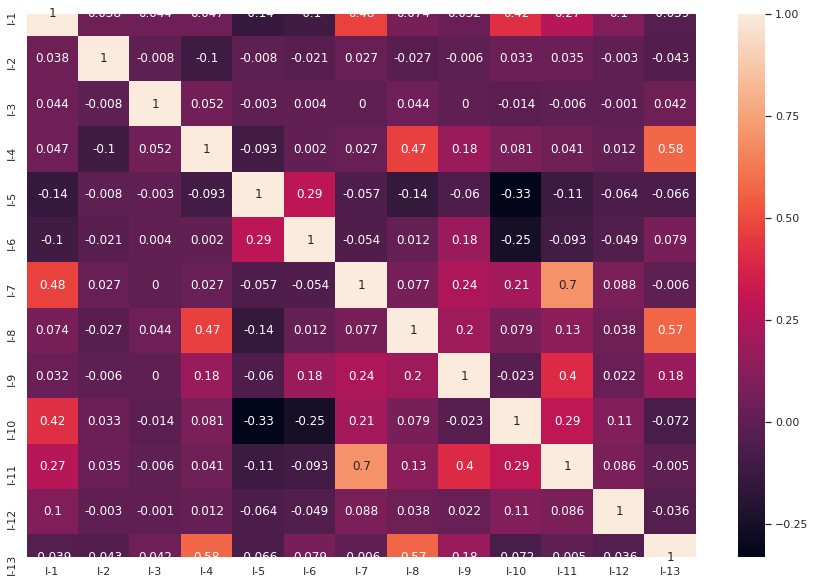

In [183]:
# Heat Map of Integers
integer_correlations = toyDF_PD.iloc[:,1:14].corr()
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(integer_correlations.round(3), xticklabels=integer_correlations.columns, yticklabels=integer_correlations.columns, annot=True)
plt.show()

/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


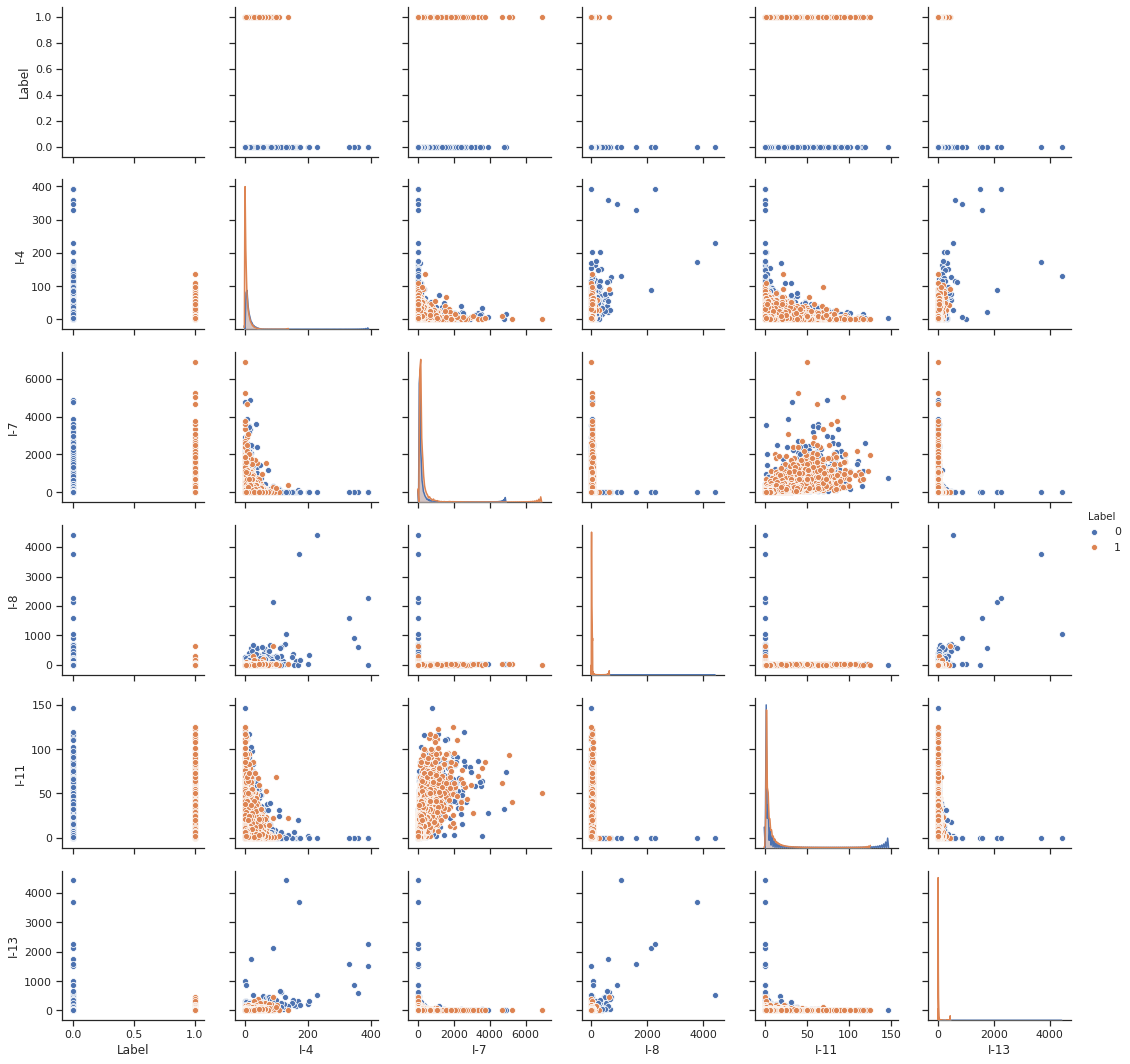

In [189]:
# Plot a scatterplot matrix for I-1 through I-13
tempDF_PD = toyDF.select(['Label', 'I-4', 'I-7', 'I-8', 'I-11', 'I-13']).toPandas()
sns.set(style="ticks")
sns.pairplot(tempDF_PD, hue="Label")

### Categorical Features

The categorical features frequency table below shows us the most frequently occuranced values and relative %. The categorical features have a fairly wide range of frequency distribution. We show the results of features C-1 to C-3 as examples. Since we do not know what the values represent, the frequency does not really help us understand the data. In our quest to make sense of the data, we have tried binning the categorical features into 7 bins to see if there is any feature that may indicate the day of week. Since the data is from 7 consecutive days, if there is any time series indicator, we would expect the feature to show even distribution once it is binned into 7 bins. However, none of the features shows this. 

In [12]:
# Show top counts for each categorical variable
for cat in toyDF_PD.iloc[:,14:17]:
    print('='*6,'Feature', cat, '='*6)
    print((toyDF_PD[cat].value_counts()/len(toyDF_PD)).head())
    print()

====== Feature C-1 ======
05db9164    0.499728
68fd1e64    0.167386
5a9ed9b0    0.083753
8cf07265    0.049630
be589b51    0.032896
Name: C-1, dtype: float64

====== Feature C-2 ======
38a947a1    0.114269
207b2d81    0.043174
38d50e09    0.038538
1cfdf714    0.036882
287130e0    0.035558
Name: C-2, dtype: float64

====== Feature C-3 ======
            0.033908
d032c263    0.024944
02cf9876    0.010748
9143c832    0.010015
aa8c1539    0.009827
Name: C-3, dtype: float64



#### Correlation Matrix
As part of feature selection, we will now attempt to spot collinarity among the features. Since none of the features is labeled, we cannot apply any common knowledge about possible correlations among them. Therefore, we decide use the Spark Dataframe built-in function to compute correlation numbers for all unique pairs of features and the label for the full training set. The results have been filtered to only display values > 0.5. Five pairs satisfy this requirement (I-4 and I-8, I-4 and I-13, I-7 and I-11, I-8 and I-13, I-5 and C-9). However, the lmplots for the integer feature pairs suggest a rather weak correlation as we see that the correlation is mostly driven by the outliers. Unfortunately, the correlation matrix did not help us rule out any features.

In [38]:
### DO NOT RE-RUN THIS! (This takes 2+ hours to run) ###
# Computes the correlation numbers for all unique pairs of features of trainDF. 
def cal_corr (DF) : 
    feature_list = ['Label']
    for i in range(1, 14): feature_list.append('I-'+str(i))
    for i in range(1, 27): feature_list.append('C-'+str(i))

    # Create an empty dataframe with the feature names as rows and columns to store the correlation matrix.
    corr_df = pd.DataFrame(index=feature_list, columns=feature_list)

    # Cast categorical features from String to IntegerType to perform correlation calculation.
    for i in range(1,27):
        feature = 'C-'+str(i)
        DF = DF.withColumn(feature, conv(DF[feature], 16, 10).cast(IntegerType()))    
    DF = DF.fillna(0)
    
    # Fill in the correlation matrix using the full training set. 
    for i in range(40):
        for j in range(i):
            row = feature_list[i]
            col = feature_list[j]
            corr_df[row][col] = DF.corr(row, col)
    return corr_df
        
corrDF = cal_corr(trainDF)
corrDF.to_pickle('correlation.pkl')

In [58]:
corrDF.fillna('').round(2)

,Label,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,...,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
Label,,0.103828,0.0443216,0.00984961,-0.0556405,-0.076566,-0.055773,0.0847263,-0.0274725,0.0240073,...,-0.0962269,0.00564899,-0.00125871,-0.0380658,0.00386597,0.00495797,0.0652947,0.0064596,0.0244528,-0.0215674
I-1,,,0.0339716,0.0383809,0.0806906,-0.0687702,-0.0581138,0.476672,0.0965647,0.0679653,...,-0.0582526,0.0215769,0.0295065,0.00473432,0.00792181,0.00129096,0.0302416,0.0113197,0.00775406,0.0141275
I-2,,,,-0.00827489,-0.0813955,-0.00630637,-0.0132656,0.0252189,-0.0279426,-0.00474384,...,-0.00856402,-0.00917917,-0.00680003,-0.0119147,-0.00840724,0.00262661,0.00809347,0.00328248,-0.00409659,-0.0208811
I-3,,,,,0.0418826,-0.00346479,0.00557462,0.000404332,0.0447908,-0.000454595,...,0.00293972,0.0173975,0.0228376,0.0416192,-0.00264903,0.00198543,-0.00271486,0.00816385,0.00370778,0.00827124
I-4,,,,,,-0.094478,0.0156165,0.0383694,0.504521,0.194227,...,-0.0172822,0.00786074,0.0332432,0.064275,0.0148459,-0.0041344,-0.015545,-0.00252151,0.00237057,0.0213757
I-5,,,,,,,0.00212302,-0.056095,-0.109379,-0.0684271,...,0.00741697,-0.0114701,0.00192056,0.00894739,-0.00979897,-0.000440369,-0.0100962,-0.0041648,0.00237694,0.00884853
I-6,,,,,,,,-0.0269472,0.0220709,0.187072,...,-0.0520681,0.00305647,-0.0266711,-0.0103991,-0.00387489,-0.00454726,0.00314552,-0.0117998,0.00460633,-0.020973
I-7,,,,,,,,,0.0767185,0.232887,...,-0.0330705,0.0336603,0.0279777,-0.015466,0.00630088,-0.00130041,0.0306451,0.0124505,-0.00256515,0.013898
I-8,,,,,,,,,,0.206266,...,-0.0195795,0.0155548,-0.000792609,0.0272718,0.0196156,-0.00232279,-0.0249942,-0.0261007,-0.0131872,-0.00244514
I-9,,,,,,,,,,,...,-0.0281313,0.0208724,0.00294354,-0.00532251,0.00895608,-0.00610078,0.0130442,-0.0010806,0.0157147,-0.0125642


In [55]:
# Create a new Pandas dataframe to store only correlation values > 0.5 and hide all the NAs for pretty printing.
s_corrDF = corrDF[corrDF > 0.5].dropna(how='all', axis = 1).dropna(how='all')
s_corrDF = s_corrDF.fillna('')
s_corrDF.to_pickle('correlation_subset.pkl')
s_corrDF.round(2)

,I-8,I-11,I-13,C-9
I-4,0.504521,,0.613096,
I-5,,,,0.514671
I-7,,0.683299,,
I-8,,,0.630637,


/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


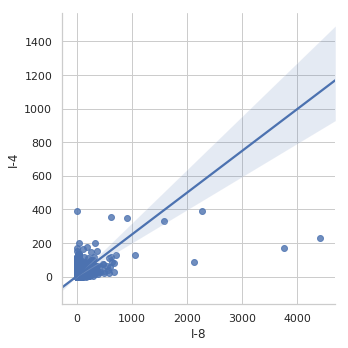

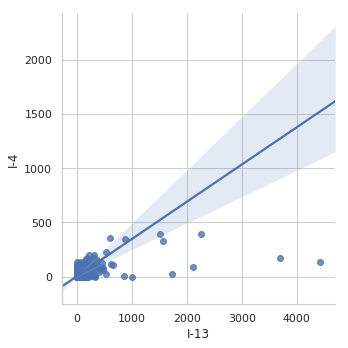

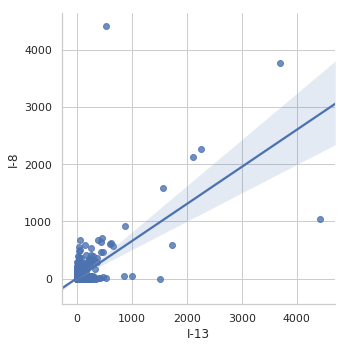

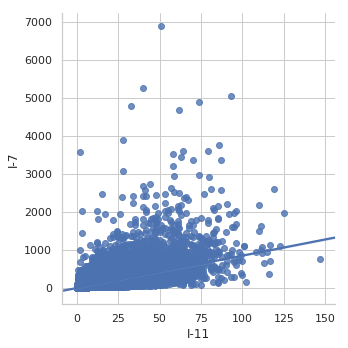

In [61]:
sns.lmplot(y = 'I-4', x = 'I-8', data=toyDF_PD)
sns.lmplot(y = 'I-4', x = 'I-13', data=toyDF_PD)
sns.lmplot(y = 'I-8', x = 'I-13', data=toyDF_PD)
sns.lmplot(y = 'I-7', x = 'I-11', data=toyDF_PD)

# IV. Algorithem Implementation

### Model Summary

We constructed four models to compare the performances with different algorithms, data processing methodology, and hyperperemeter. 

> Model I (Baseline): Decision tree algorithm with integer features (I1-I13 exclude I12 - no preprocessing)

> Model II : Random forest algorithm with integer features (I1-I13 exclude I12 - no preprocessing)

> Model III : Random forest algorithm with all features
        - Scaled integer features (I1-I13) 
        - Frequency-indexed, threshold controlled (max 100) categorical features (C1-C26, exclude C22) 
        
> Model IV: Model III plus gradient boosting

The performance of the model is outlined below: 


In [7]:
data = {'Model':['(Baseline) Model I', 'Model II', 'Model III', 'Model IV'], 'Log-Loss':[0.51395, 0.512107, 0.0, 0.0], 'F-1':[0.7581, 0.7589, 0.0, 0.0], 'Max Depth':[8.0, 8.0, 0.0, 0.0], 'Run-Time (sec)':[533.0, 3125.8, 0.0, 0.0]}
df = pd.DataFrame(data) 
df  

,Model,Log-Loss,F-1,Max Depth,Run-Time (sec)
0,(Baseline) Model I,0.513950,0.7581,8.0,533.0
1,Model II,0.512107,0.7589,8.0,3125.8
2,Model III,0.000000,0.0000,0.0,0.0
3,Model IV,0.000000,0.0000,0.0,0.0


### Pre-Processing
The integer features have already been cast into Integer Type. The categorical features are re-indexed using String Indexer. Our analysis of the categorical features in its hexidemical form did not provide much insight. We decided to use a indexer since the resulting data representation is more space efficient and scalable. The String Indexer assigns a unique integer value to each unique feature value and preserves the frequency rank of the feature values. For example, the most frequent feature value will be assigned a '0' by the Indexer, the second most frequent feature value will be assigned a '1', etc. This data representation is much smaller than the hexidecimal version and it will help eliminate rare feature values in the modeling process. 

#### Integer Features Pre-Processing


In [8]:
#Fill all Nulls or NAs with mean values
def imputers(dataframe):
    inputCols = []
    outputCols = []
    for i in range(1,14):
        feature = 'I-'+str(i)
        dataframe =  dataframe.withColumn(feature, dataframe[feature].cast(DoubleType())) 
        inputCols.append(feature)
        outputCols.append(feature)
    imputer = Imputer(strategy="mean",
        inputCols=inputCols,
        outputCols=outputCols)
    return imputer.fit(dataframe).transform(dataframe)


In [9]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY
#toy_imputed_DF = imputers(toyDF)
#train_imputed_DF = imputers(trainDF)
#validation_imputed_DF = imputers(validationDF)
#test_imputed_DF = imputers(testDF)
mini_imputed_DF = imputers(miniValDF)


In [1]:
mini_imputed_DF.show()

NameError: name 'mini_imputed_DF' is not defined

In [ ]:
#Check if there are any more nulls on the toy set
def getEmptyCounts(dataframe):
    print("Missing values")
    print("--------------------------------------")
    col_name = all_columns[4]
    count = dataframe.filter((dataframe[col_name] == "") | dataframe[col_name].isNull() | isnan(dataframe[col_name])).count()
    print('{}\t\t\t {}'.format(col_name, count))

print("--------------------------------------")
print("TOY SET")
print("--------------------------------------")
       
%time getEmptyCounts(mini_imputed_DF)

In [ ]:
####scale the Integer Features

In [13]:

all_columns = ['Label']
for i in range(1,14): all_columns.append('I-'+str(i))
for i in range(1,27): all_columns.append('C-'+str(i))
    
continuous_indexes = [i for i in range(1,14)]
category_indexes = [i for i in range(14,40)]


In [14]:
def assembler_indexers(dataframe):
    assemblers = [VectorAssembler(inputCols=[all_columns[i]], outputCol=all_columns[i]+"-Vector") for 
                i in continuous_indexes ]
    pipeline = Pipeline(stages=assemblers)
    assembled_dataframe = pipeline.fit(dataframe).transform(dataframe)
    return assembled_dataframe

In [15]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY
#toy_assembled_indexedDF   = assembler_indexers(toy_imputed_DF)
#train_assembled_indexedDF   = assembler_indexers(train_imputed_DF)
#validation_assembled_indexedDF   = assembler_indexers(validation_imputed_DF)
#test_assembled_indexedDF   = assembler_indexers(test_imputed_DF)
mini_assembled_indexedDF   = assembler_indexers(mini_imputed_DF)


In [3]:
mini_assembled_indexedDF.show()

In [17]:
def scaler_indexers(dataframe):
    indexers = [StandardScaler(inputCol=all_columns[i]+"-Vector", outputCol=all_columns[i]+"-Scaled",
                        withStd=True, withMean=True).fit(dataframe) for 
                i in continuous_indexes ]
    pipeline = Pipeline(stages=indexers)
    scaled_dataframe = pipeline.fit(dataframe).transform(dataframe)
    for i in continuous_indexes:
        scaled_dataframe = scaled_dataframe.drop(all_columns[i])
    for i in continuous_indexes:
        scaled_dataframe = scaled_dataframe.drop(all_columns[i]+"-Vector")
    return scaled_dataframe


In [18]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY
#toy_scaled_indexedDF   = scaler_indexers(toy_assembled_indexedDF)
#mini_scaled_indexedDF   = scaler_indexers(mini_assembled_indexedDF)
#train_scaled_indexedDF   = scaler_indexers(train_assembled_indexedDF)
#validation_scaled_indexedDF   = scaler_indexers(validation_assembled_indexedDF)
#test_scaled_indexedDF   = scaler_indexers(test_assembled_indexedDF)
mini_scaled_indexedDF   = scaler_indexers(mini_assembled_indexedDF)

In [5]:
mini_scaled_indexedDF.show()

### Categorical Features Pre-Processing

In [20]:
def string_indexers(dataframe):
    indexers = [StringIndexer(inputCol=all_columns[i], outputCol=all_columns[i]+"-Index").fit(dataframe) for 
                i in category_indexes ]
    pipeline = Pipeline(stages=indexers)
    indexed_dataframe = pipeline.fit(dataframe).transform(dataframe)
    for i in category_indexes:
        indexed_dataframe = indexed_dataframe.drop(all_columns[i])
    return indexed_dataframe

#### Apply String Indexer to all datasets

In [21]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY

#toy_S_indexedDF   = string_indexers(toy_scaled_indexedDF)
#train_S_indexedDF = string_indexers(train_scaled_indexedDF)
#validation_S_indexedDF = string_indexers(validation_scaled_indexedDF)
#test_S_indexedDF = string_indexers(test_scaled_indexedDF)
mini_S_indexedDF = string_indexers(mini_scaled_indexedDF)


#### Binning categorical features that has rank greater than 100 - 999

In [22]:
# Help function: We replace all the categorical values that are greater than 100 with 999 (aka we only keep the 100 most frequently appear categorical values)

from pyspark.sql.functions import when

def drop_threshold(df, threshold, replace_val, column_names):
    '''Help function that replace all values greater than a threshold with the replacement value'''
    for col in column_names:
        df=df.withColumn(col, when(df[col]>threshold, replace_val).otherwise(df[col]))
    return df

#### Apply drop_threshold to all indexed data frames

In [23]:
categorical_columns=["C-1-Index","C-2-Index","C-3-Index","C-4-Index","C-5-Index","C-6-Index","C-7-Index","C-8-Index"
                     ,"C-9-Index","C-10-Index","C-11-Index","C-12-Index", "C-13-Index","C-14-Index","C-15-Index",
                     "C-16-Index","C-17-Index","C-18-Index","C-19-Index","C-20-Index","C-21-Index", "C-22-Index",
                     "C-23-Index","C-24-Index","C-25-Index","C-26-Index"]

In [24]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY

#toy_S_indexed_ranked_DF = drop_threshold (toy_S_indexedDF, 100, 999, categorical_columns)
#train_S_indexed_ranked_DF = drop_threshold (train_S_indexedDF, 100, 999, categorical_columns)
#validation_S_indexed_ranked_DF = drop_threshold (validation_S_indexedDF, 100, 999, categorical_columns)
#test_S_indexed_ranked_DF = drop_threshold (test_S_indexedDF, 100, 999, categorical_columns)
mini_S_indexed_ranked_DF = drop_threshold (mini_S_indexedDF, 100, 999, categorical_columns)


#### Apply Brieman to all indexed and ranked data frames

In [25]:
def Breiman(df, label_column, column_names):
    '''This function calculates the average of a given column conditional on the value of another column'''
    for col in column_names:
        print(col)
        w = Window().partitionBy(col)
        df = df.withColumn(col+"B", avg(label_column).over(w))
        df.drop(col)
        df.persist()
    return df;

In [26]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY
#toy_S_indexed_breiman_DF = Breiman(toy_S_indexed_ranked_DF, "Label", categorical_columns)
#train_S_indexed_breiman_DF = Breiman(train_S_indexed_ranked_DF, "Label", categorical_columns)
#validation_S_indexed_breiman_DF = Breiman(validation_S_indexed_ranked_DF, "Label", categorical_columns)
#test_S_indexed_breiman_DF = Breiman(test_S_indexed_ranked_DF, "Label", categorical_columns)
mini_S_indexed_breiman_DF = Breiman(mini_S_indexed_ranked_DF, "Label", categorical_columns)


C-1-Index
C-2-Index
C-3-Index
C-4-Index
C-5-Index
C-6-Index
C-7-Index
C-8-Index
C-9-Index
C-10-Index
C-11-Index
C-12-Index
C-13-Index
C-14-Index
C-15-Index
C-16-Index
C-17-Index
C-18-Index
C-19-Index
C-20-Index
C-21-Index
C-22-Index
C-23-Index
C-24-Index
C-25-Index
C-26-Index


Below we verify that we generate the correct output for Breiman. 

In [27]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY
#toy_S_indexed_breiman_DF.show(10)
#train_S_indexed_breiman_DF.show(10)
#validation_S_indexed_breiman_DF.show(10)
#test_S_indexed_breiman_DF.show(10)
mini_S_indexed_breiman_DF.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------

#### Now write them as Parquets so that you can load and use directly for modeling

In [28]:
# DO NOT RUN THE WHOLE CELL - Comment As NECESSARY
#toy_S_indexed_breiman_DF.write.parquet("data/toy_preprocessed.parquet")
#train_S_indexed_breiman_DF.write.parquet("data/train_preprocessed.parquet")
#validation_S_indexed_breiman_DF.write.parquet("data/validation_preprocessed.parquet")
#test_S_indexed_breiman_DF.write.parquet("data/test_preprocessed.parquet")
mini_S_indexed_breiman_DF.write.parquet("data/mini_preprocessed.parquet")


### Revalidate the pre-processed data

In [29]:
mini_preprocessedDF = spark.read.load("data/mini_preprocessed.parquet")

print(mini_preprocessedDF.count())

mini_preprocessedDF.show()

137290
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+

### Modeling
We will now begin the model building process. We explored different models using a smaller dataset on a local machine and tested them. The trial models were trained using the toy dataset from the EDA, which is 1.5% of the full training set. Then predictions were made on a mini validation set, which is also 1.5% of the full validation set. 

After this process, we moved to final training and testing on the full data set.  We split the provided Kaggle train dataset into 80% train and 20% test and conducted our training and testing with this. The provided code and results are from the full dataset testing and we included the actual GCP submitted Python jobs. We also conducted testing to determine the optimal max depth for the decision tree model which is included after the presentation of the decision tree model. We concluded a max depth of 8 was optimal which was used in this model.

We begin with a base model using a single Decision Tree without any preprocessing and transition to Random Forest with more optimizations in subsequent models and ultimately Gradient Boosted Tree.

#### Model I - Base Model (Decision Tree with ONLY Integer Features)
We start with a base model with Integer features only. As explained in the EDA, I-12 has been dropped due to the high percentage of missing values. We explore the optimal MaxDepth hyperparameter using the toy dataset below.

In [ ]:
## HELPER FUNCTIONS ##
# Input: Spark Dataframe and list of features to ignore
# Output: Transformed feature format to feed to Decision Tree model
# Function builds a vector from the given Spark Dataframe, excluding the features
# in 'ignore_list'. It uses VectorAssembler to build a vector and then transform
# to 'label | [feature 1, feature 2, etc]' format.
def vector_transform(DF, ignore_list):
    # Create a list of features 
    assemblerInputs = []
    for i in range(1,14): assemblerInputs.append('I-'+str(i))
    for i in range(1,27): assemblerInputs.append('C-'+str(i))
    
    # Build vector for decision tree for dataset
    assembler = VectorAssembler(inputCols=[x for x in DF.columns if x not in ignore_list],
                                outputCol='features')

    # Transform the data for train data set
    output = assembler.transform(DF)
    #print(output.select("Label", "features").show(truncate=False))
    return output

# Compute log loss on the given Spark Dataframe.
def logLoss(predDF):
    # Define a function clamp to restrict the values of probability to be greater than 0 and less than one
    def clamp(n):
        epsilon = .000000000000001
        minn = 0 + epsilon
        maxn = 1 - epsilon
        return max(min(maxn, n), minn)
    
    # Define a UDF to extract the first element of the probability array returned which is probability of one
    firstelement=udf(lambda v:clamp(float(v[1])))   #,FloatType() after [] was inserted and removed for epsilon
    
    # Create a new dataframe that contains a probability of one column (true)
    predict_df = predDF.withColumn('prob_one', firstelement(predDF.probability))
    
    # Compute the log loss for the spark dataframe for each row
    row_logloss = (predict_df.withColumn(
        'logloss', -f.col('Label')*f.log(f.col('prob_one')) - (1.-f.col('Label'))*f.log(1.-f.col('prob_one'))))

    logloss = row_logloss.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']
    return logloss

# Produce additional metrics - precision, recall, F1, False Positive Rate for Label 0
# False Positive Rate for Label 1, and Accuracy.
def multiMetrics(predDF):
    x = predictions.rdd.map(lambda x:(x[43], float(x[0]))).collect()
    predictionAndLabels = sc.parallelize(x)
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)

    # Overall statistics
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    fpr0 = metrics.falsePositiveRate(0.0)
    fpr1 = metrics.falsePositiveRate(1.0)
    accuracy = metrics.accuracy
    
    return [f1Score, precision, recall, fpr0, fpr1, accuracy]

In [ ]:
# Explore the best MaxDepth by modeling with MaxDepth 1 to 15. We decided on 8 as the minimum log loss.
DT_results = []
for i in range(1,16):
    time0 = time.time()
    dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Label', maxDepth = i)
    dtModel = dt.fit(toyDF_trans)
    predictions = dtModel.transform(miniValDF_trans)
    log_loss = logLoss(predictions)
    evaluator = BinaryClassificationEvaluator(labelCol='Label')
    auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    multi_metrics = multiMetrics(predictions)
    wall_time = time.time()-time0
    current = [i, log_loss, auroc, auprc, wall_time] + multi_metrics
    DT_results.append(current)
DT_base_PD = pd.DataFrame(DT_results, columns=['MaxDepth', 'Log Loss', 'Area Under ROC', 'Area Under PR', 
                                               'Wall Time', 'F1', 'Precision', 'Recall', 'False Positive for 0', 
                                               'False Positive for 1', 'Accuracy'])
DT_base_PD.to_pickle('DT_base_PD.pkl')

**RESULTS** - As shown in the following metrics table, the base model performs best at MaxDepth of 8. From the plot of the log loss at each MaxDepth, we can see that the log loss begins to shoot up beyond MaxDepth of 10. The model begins to overfit. Therefore, we decided to use a MaxDepth of 8 for all subsequent models. 

In [5]:
DT_base_PD = pd.read_pickle('DT_base_PD.pkl')
print('Decision Tree Base Model on Integer Features (I-12 Excluded)')
DT_base_PD.round(4)

Decision Tree Base Model on Integer Features (I-12 Excluded)


,MaxDepth,Log Loss,Area Under ROC,Area Under PR,Wall Time,F1,Precision,Recall,False Positive for 0,False Positive for 1,Accuracy
0,1,0.5713,0.5000,0.2583,19.0098,0.7417,0.7417,0.7417,1.0000,0.0000,0.7417
1,2,0.5438,0.3730,0.2075,17.5543,0.7450,0.7450,0.7450,0.7391,0.0865,0.7450
2,3,0.5427,0.3744,0.2080,20.7762,0.7519,0.7519,0.7519,0.8378,0.0427,0.7519
3,4,0.5427,0.3744,0.2080,18.5538,0.7519,0.7519,0.7519,0.8378,0.0427,0.7519
4,5,0.5333,0.3569,0.1981,24.0338,0.7543,0.7543,0.7543,0.8422,0.0380,0.7543
5,6,0.5333,0.3563,0.1980,18.2033,0.7540,0.7540,0.7540,0.8490,0.0360,0.7540
6,7,0.5326,0.3513,0.1970,18.0999,0.7545,0.7545,0.7545,0.8276,0.0427,0.7545
7,8,0.5230,0.4305,0.2203,18.6788,0.7556,0.7556,0.7556,0.8208,0.0437,0.7556
8,9,0.5237,0.4771,0.2468,18.5628,0.7557,0.7557,0.7557,0.8122,0.0466,0.7557
9,10,0.5343,0.4686,0.2477,18.6695,0.7550,0.7550,0.7550,0.8225,0.0439,0.7550


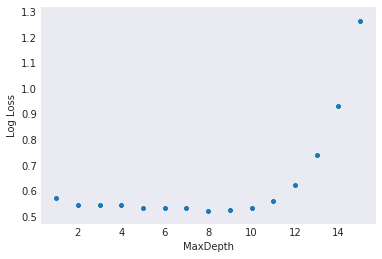

In [6]:
sns.scatterplot(x="MaxDepth", y="Log Loss", data=DT_base_PD)

#### Decision Tree Baseline Model on FULL Training Set in GCP
With the result from the toy dataset, we now run our baseline model in GCP on the full training set. Below is the model output for our Baseline model (Model I). Please see file `steve_ctr_DT_full.py` for the full GCP job.

#### Model II - Random Forest with ONLY Integer Features
We now move to a ensemble base model (random forest) with Integer features only. We again start with the toy dataset to explore the tradeoff between model performance and model complexity. We run 25-300 trees in increments of 25 in GCP to determine the optimal number. We settle on 50 trees for our analysis.  Our analysis and tests are shown in the table after this section. Increasing the number of trees doesn't improve the log loss of our model significantly. 

In [ ]:
# Before deciding on the number of trees for random forest, we ran some 
# experiments.  Below is that code.

# Explore the optimal number of trees. 
RF_results = []

# Drop I-12 and C-22 with 76% missing values
ignore = ['I-12', 'C-22', 'Label']

# Also ignore all categorical for testing purposes.
for i in range(1,27): ignore.append('C-'+str(i))
toyDF_trans = vector_transform(toyDF, ignore)
miniValDF_trans = vector_transform(miniValDF, ignore)

for i in range(25,101, 25):
    time0 = time.time()
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Label', maxDepth = 8, numTrees=i)
    rfModel = rf.fit(toyDF_trans)
    predictions = rfModel.transform(miniValDF_trans)
    log_loss = logLoss(predictions)
    evaluator = BinaryClassificationEvaluator(labelCol='Label')
    auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    wall_time = time.time()-time0
    DT_results.append([i, log_loss, auroc, auprc, wall_time])
RF_base_PD = pd.DataFrame(RF_results, columns=['# of Trees', 'Log Loss', 'Area Under ROC', 'Area Under PR', 'Wall Time'])
RF_base_PD.to_pickle('gs://'+BUCKET+'/DT_base_PD.pkl')

**RESULT** - As shown in the table below. runtime increases as we increase the number of trees. However, in this particular dataset, there is no real performance improvement (indicated by the log loss) as we add more trees. Therefore we settle on 50 trees. 

In [7]:
# The Random Forest base model was run in GCP. 
RF_base_results = [[25, 0.5148061186384715, 0.7129441053352061, 0.4708398513986878, 47.293211221694946], [50, 0.5147284397363991, 0.7129693833503822, 0.4712568999913462, 49.66066908836365], [75, 0.5147310878123429, 0.7130259983831488, 0.47125857609298394, 72.52715826034546], [100, 0.5146376411033601, 0.713217585186116, 0.47126466266269373, 94.9700391292572], [125, 0.5147089954233935, 0.7130800360274068, 0.47117960762957917, 121.45633506774902], [150, 0.5146272517069513, 0.7132301926912183, 0.47138301030718804, 147.58476972579956], [175, 0.514664333953878, 0.7132073549767876, 0.4710932045752643, 180.45838832855225], [200, 0.5145995514880527, 0.7133221745680751, 0.4712582698044433, 212.79541611671448], [225, 0.5146235553728141, 0.7132656992540451, 0.47123874036264213, 244.2760157585144], [250, 0.5146083880536135, 0.7133038337478641, 0.4711746998709915, 280.1483209133148], [275, 0.5146193394921169, 0.7132848279827472, 0.4712132972655888, 317.7861247062683], [300, 0.5146100444919259, 0.7132738705158871, 0.47129004525591894, 350.97094988822937]]
RF_base_PD = pd.DataFrame(RF_base_results, columns=['# of Trees', 'Log Loss', 'Area Under ROC', 'Area Under PR', 'Wall Time'])
RF_base_PD

,# of Trees,Log Loss,Area Under ROC,Area Under PR,Wall Time
0,25,0.514806,0.712944,0.470840,47.293211
1,50,0.514728,0.712969,0.471257,49.660669
2,75,0.514731,0.713026,0.471259,72.527158
3,100,0.514638,0.713218,0.471265,94.970039
4,125,0.514709,0.713080,0.471180,121.456335
5,150,0.514627,0.713230,0.471383,147.584770
6,175,0.514664,0.713207,0.471093,180.458388
7,200,0.514600,0.713322,0.471258,212.795416
8,225,0.514624,0.713266,0.471239,244.276016
9,250,0.514608,0.713304,0.471175,280.148321


#### Random Forest Model on FULL Training Set in GCP
With the result from the toy dataset, we now run our Random Forest model in GCP on the full training set. Below is the model output for our model (Model II). Please see file `steve_ctr_RF_full.py` for the full GCP job.

#### Model III - Random Forest Ensemble with Scaled Integer Features and String Indexed Categorical Features
In our third model, we model with both the integer features and categorical features. The integer features are scaled and the categorical features are string indexed. We use the toy dataset to explore the best number of trees to use to ensure that our previous decision of 50 is still a good choice. Please see file `final_proj_GCP_RF_SSI2.py` for the full GCP job.

In [8]:
RF_SSI_results = [[25, 0.5115864824196125, 0.720236087741372, 0.48187903327054743, 131.18768548965454], [50, 0.5112659942801738, 0.7211600309132531, 0.4824311931109271, 146.69110465049744], [75, 0.5112816311829911, 0.7210030176454765, 0.4832222171430406, 171.36151885986328], [100, 0.5114092141569933, 0.7207305292576047, 0.4830760176250949, 204.73024129867554], [125, 0.5113407564558776, 0.7208726834575466, 0.4829283288030773, 243.99114227294922], [150, 0.5113387879088483, 0.7210460904838208, 0.48314403357031244, 283.71192598342896], [175, 0.5113008177256501, 0.7209885625018997, 0.48316680032237724, 327.99223232269287], [200, 0.5113534677806418, 0.7210343398465119, 0.483208088170881, 379.50353240966797]]
RF_SSI_PD = pd.DataFrame(RF_SSI_results, columns=['# of Trees', 'Log Loss', 'Area Under ROC', 'Area Under PR', 'Wall Time'])
RF_SSI_PD

,# of Trees,Log Loss,Area Under ROC,Area Under PR,Wall Time
0,25,0.511586,0.720236,0.481879,131.187685
1,50,0.511266,0.721160,0.482431,146.691105
2,75,0.511282,0.721003,0.483222,171.361519
3,100,0.511409,0.720731,0.483076,204.730241
4,125,0.511341,0.720873,0.482928,243.991142
5,150,0.511339,0.721046,0.483144,283.711926
6,175,0.511301,0.720989,0.483167,327.992232
7,200,0.511353,0.721034,0.483208,379.503532


#### Random Forest Model with Pre-Processing on FULL Training Set in GCP
With the result from the toy dataset, we now run our Random Forest model with pre-processing in GCP on the full training set with 50 trees. Below is the model output for our model (Model III). Please see file `blah blah blah.py` for the full GCP job.

#### Model IV- Random Forest with Gradient Boosted 

We now move to a ensemble base model with Integer and categorical features only. Please see file `bla blah blah.py` for the full GCP job

### Metrics Section for Evaluating Performance

#### Log loss

Log loss was the primary metric that we judged performance with due to it's appropriateness in this modeling situation and use by Kaggle. Log loss measures the performance of a classification model whose output is a probability value between 0 and 1. The loss increases as the predicted probability moves away from the actual label. So in our case, predicting a click thru (1) with a low probability of .05 when the actual ground truth label is 1 would be bad and result in a high loss value. A perfect model will have a log loss of 0.  So lower values are better for log loss.

In [10]:
# Define a function clamp to restrict the values of probability to be greater than 0 and less than one
def clamp(n):
    epsilon = .000000000000001
    minn = 0 + epsilon
    maxn = 1 - epsilon
    return max(min(maxn, n), minn)

print(clamp(0.0))

1e-15


In [11]:
# Define a UDF to extract the first element of the probability array returned which is probability of one
firstelement=udf(lambda v:clamp(float(v[1])))   #,FloatType() after [] was inserted and removed for epsilon
predictions.select(firstelement('probability')).show(3)

+---------------------+
|<lambda>(probability)|
+---------------------+
|  0.18761904761904763|
|   0.2509090909090909|
|  0.18056174765938476|
+---------------------+
only showing top 3 rows



In [12]:
# Create a new dataframe that contains a probability of one column (true)
predict_df = predictions.withColumn('prob_one', firstelement(predictions.probability))
predict_df.select('prob_one').show(10)
logloss = 0.0

+-------------------+
|           prob_one|
+-------------------+
|0.18761904761904763|
| 0.2509090909090909|
|0.18056174765938476|
| 0.2509090909090909|
| 0.4834123222748815|
| 0.4144235652615541|
|0.11853317102860621|
| 0.3448275862068966|
|0.14357429718875503|
|0.19163879598662206|
+-------------------+
only showing top 10 rows



In [13]:
# Compute the log loss for the spark dataframe for each row

row_logloss = (
    predict_df.withColumn(
        'logloss', -f.col('Label')*f.log(f.col('prob_one')) - (1.-f.col('Label'))*f.log(1.-f.col('prob_one'))
    )
)

logloss = row_logloss.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']

In [14]:
# Examine the log loss
row_logloss.select('Label', f.round('logloss', 20), 'prediction', 'probability', 'prob_one').show(15)

+-----+-------------------+----------+--------------------+-------------------+
|Label| round(logloss, 20)|prediction|         probability|           prob_one|
+-----+-------------------+----------+--------------------+-------------------+
|    0| 0.2077858956598899|       0.0|[0.81238095238095...|0.18761904761904763|
|    0| 0.2888949288769903|       0.0|[0.74909090909090...| 0.2509090909090909|
|    0|0.19913623160457605|       0.0|[0.81943825234061...|0.18056174765938476|
|    0| 0.2888949288769903|       0.0|[0.74909090909090...| 0.2509090909090909|
|    1| 0.7268853201917954|       0.0|[0.51658767772511...| 0.4834123222748815|
|    1| 0.8808667236750185|       0.0|[0.58557643473844...| 0.4144235652615541|
|    0|0.12616790806053452|       0.0|[0.88146682897139...|0.11853317102860621|
|    1| 1.0647107369924282|       0.0|[0.65517241379310...| 0.3448275862068966|
|    1|  1.940902627324691|       0.0|[0.85642570281124...|0.14357429718875503|
|    1| 1.6521429496699926|       0.0|[0

In [15]:
# Model log loss total
print("log loss = ", logloss)

log loss =  0.5345480444452959


#### Area under the Curve for Receiver Operating Characteristic and Precision Recall

The ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is plotted with true positive rate(TPR) against the false positive rate (FPR) where TPR is on y-axis and FPR is on the x-axis. An excellent model has AUC near 1 which means it has good measure of separability in distinguishing 1s from 0s. A poor model has AUC near 0 which means it has a worse measure of separability. In fact, this model is predicting 0s as 1s and 1s as 0s. Last, when AUC is 0.5, it means the model has no class separation capacity whatsoever and you could do as well by guessing with a coin toss.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve
represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall 
relates to a low false negative rate.  Again, high numbers are good with this curve as close to one as possible.

In [19]:
# Compute Area under the Curve for Receiver Operating Characteristic and Precision Recall - the bigger the area the better the model.

evaluator = BinaryClassificationEvaluator(labelCol='Label')

auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.5231
Area under PR Curve: 0.2654


#### Other Evaluation Metrics

We evaluated numerous statistics in tuning our models and evaluating the best models.  Here are some of the statistics we used.

-Accuracy - Accuracy is the most intuitive performance measure. It is simply a ratio of correctly predicted observation to the total observations. While intuitive, it is not the best measure of a binary classifier. 

-Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. A high ratio is good.

-Recall (Sensitivity) is the ratio of correctly predicted positive observations to all of the observations in actual class - positive. The question recall answers is: of all the situations that truly clicked thru, how many did we label as clicking thru? 

-F1 Score is the weighted average of Precision and Recall. This score takes both false positives and false negatives into account. It is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution which we do here with 76% being 0 and 24% being 1. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different as they are here with CTR, it’s better to look at both Precision and Recall and the F1 score. 

-A confusion matrix allows the visualization of the performance of an algorithm. Each row of the matrix represents the instances in a predicted class while each column represents the instances in the ground truth actual class (or vice versa). A confusion matrix makes it easy to see if the classifier is confusing two classes (i.e. commonly mislabeling one as another).

-False positive rate - shows the percentage the model is wrong at predicting a positive (1 value) when the actual value is 0.  You want a low false positive rate.  

In [ ]:
# Metrics

from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

x = predictions.rdd.map(lambda x:(x[43], float(x[0]))).collect()
predictionAndLabels = sc.parallelize(x)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
fpr0 = metrics.falsePositiveRate(0.0)
fpr1 = metrics.falsePositiveRate(1.0)
accuracy = metrics.accuracy
print("Summary Statistics")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 score = %s" % f1Score)
print("False positive rate 0 = %s" % fpr0)
print("False positive rate 1 = %s" % fpr1)
print("Accuracy = %s" % accuracy, '\n')
print("Confusion Matrix")
print(metrics.confusionMatrix().toArray(), '\n')

#Statistics by class
labels = predictions.rdd.map(lambda lp: lp.Label).distinct().collect()
print("Class Statistics")
for label in sorted(labels):
    print("Class %s Precision = %s" % (label, metrics.precision(label)))
    print("Class %s Recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 score = %s" % (label, metrics.fMeasure(float(label), beta=1.0)), "\n")

# # Weighted stats
print("Weighted Statistics")
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted F1 score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

# V. Application of Course Concepts (NAGA/STEVE - anything to add?)

**Columnar Data Storage (Parquet) and Data Processing (Spark DataFrame)**

Given the data volume, finding the right way to efficiently store and distributedly process data prove critical before we could even begin data exploration. The provided training file contains ~46 million data points (45,840,617 rows in a 11GB file). Obviously scalability is a key challenges from the get-go. While Pandas is a useful tool, it can only process data of up ~1GB. Even though we have been using RDD as a distributed system in class, it is not an attrative option because it performs row based operations. With 40 columns of data, we need columnar data storage to achieve better compression, speed up data lookup, and reduce runtime. I/O is significantly reduced since Parquet allows us to scan only the data we need without reading the whole row of data. Consequently, we convert the files to Parquet and build our Spark DataFrame on top of Parquet to leverage the efficiecy and scalability of both systems.
 
**Data Processing - Normalization, Indexing, and Brieman**

Once we are able to examine the data, we quickly learn that we will need to make several important decisions about data processing and feature selection.  The 39 features in the dataset include both numerical and categorical format with no information provided about what the features represent. We apply data processing techniques we learn in class to transform the data. For the integer features, we apply the standard scaler to normalize the data since we do not know what they represent. For the categorical features, we changed the original hexidemical representation to an index using String Indexer. One Hot Encoding is not feasible given the number of unique values (several million) in some of the features so we looked into binning and applied Breiman to our categorical features.
 

**Decision Tree**

Last but not least, we built an in-depth understanding of decision tree concept that was briefly covered in Week 12 through our modeling process. We began with a single tree and tuned the MaxDepth hyperparameter with it. We found the optimal depth that minimizes the bias variance tradeoff. We showed that beyond certain depth (8-9), the model began overfitting. Then we used an ensemble random forest model with gradient boosting to optimize model performnace. As we move to an ensemble model, we have to weigh the tradeoff between model performance and model complexity. Increasing the number of trees can dramatically increase the model complexity and runtime. In the end, we decided to run the models on 50 trees.



# Addendum

### Codes for data preparation

In [ ]:
# We build toy_Pauline using the below command line
#!cat 'data/train.txt' | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .0001) print $0}' > 'data/toy_pauline.txt'

In [ ]:
# Creating 80-20 split and used the same code to create toy dataset - which is 1.5% of the train text
import random
fin = open("/path/to/input.txt", 'rb')
f80out = open("/path/to/train_80.txt", 'wb')
f20out = open("/path/to/validation_20.txt", 'wb')
for line in fin:
    r = random.random()
    if r < 0.8:
        f80out.write(line)
    else:
        f20out.write(line)
fin.close()
f80out.close()
f20out.close()
#converts a line into tuple
def read_tuple(line):
    values = line.split("\t")
    return (
    values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7], values[8], values[9],
    values[10], values[11], values[12], values[13], values[14], values[15], values[16], values[17], values[18], values[19],
    values[20], values[21], values[22], values[23], values[24], values[25], values[26], values[27], values[28],
    values[29], values[30], values[31], values[32], values[33], values[34], values[35], values[36], values[37],
    values[38], values[39])
#load the airline data and covert into an RDD of tuples
lines = sc.textFile("data/train_80.txt").map(read_tuple)
#convert the rdd into a dataframe
df = sqlContext.createDataFrame(lines, ['Label','I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9',
                                        'I-10','I-11','I-12','I-13','C-1','C-2','C-3','C-4','C-5','C-6',
                                        'C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15',
                                        'C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24',
                                        'C-25','C-26'])
df.write.parquet("data/train_80.parquet")
#load the airline data and covert into an RDD of tuples
lines = sc.textFile("data/validation_20.txt").map(read_tuple)
#convert the rdd into a dataframe
df = sqlContext.createDataFrame(lines, ['Label','I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9',
                                        'I-10','I-11','I-12','I-13','C-1','C-2','C-3','C-4','C-5','C-6',
                                        'C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15',
                                        'C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24',
                                        'C-25','C-26'])
df.write.parquet("data/validation_20.parquet")

In [ ]:
# Find the number of data points without any missing values in all features. 
def NonNA(features):
    for feature in features:
        if feature == '': return False
    return True
        
compTrainRDD = trainRDD.map(lambda line: line.split('\t')) \
                       .filter(NonNA) 
CTrain = compTrainRDD.collect()
CTrain 

In [120]:
len(CTrain)

605255

### Kaggle Submission postprocessing after GCP run
We use our Decision Tree base model to generate predictions for the test data and submitted to Kaggle. The score is 0.61925, which places us in the 601th place. The post processing steps after the GCP job are shown below.

In [65]:
kaggle_DT_MD10_DF = spark.read.load('data/Kaggle_DT_MD10_predictions.parquet')

In [85]:
kaggle_submit = []
for i in range(len(y_pred)):
    kaggle_submit.append((i+60000000, y_pred[i]))
kaggle_submit[0]

(60000000, 0.1668912821834972)

In [86]:
len(kaggle_submit)

6042135

In [87]:
kaggle_submit_PD = pd.DataFrame(kaggle_submit, columns=['Id', 'Predicted'])
kaggle_submit_PD.to_csv('data/kaggle.csv', index=False)